In [1]:
import torch
from torch import nn
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
import json


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
device = torch.device(device)
print(f"Using {device} device")

Using cuda device


In [2]:
from src import get_data_loaders

data_dir = os.path.join(os.getcwd(), 'Data', 'Parsed_Data_Corrected')
faste_files_to_load = 37
normalize = False
num_train_val_data = math.inf
num_test_data = math.inf
batch_size = 128
upper_threshold = True
lower_threshold = False
min_coverage = None
max_coverage = 20_000


train_loader, val_loader, test_loader = get_data_loaders(data_dir,
                                                            batch_size=batch_size,
                                                            faste_files_to_load=faste_files_to_load, 
                                                            normalize=normalize, 
                                                            train_val_data_to_load=num_train_val_data, 
                                                            test_data_to_load=num_test_data,
                                                            upper_threshold=upper_threshold,
                                                            lower_threshold=lower_threshold,
                                                            minimum_coverage=min_coverage,
                                                            maximum_coverage=max_coverage)


Loading sequences from sequences.fasta
Loading coverage from SRX9770776.faste
Loading coverage from SRX9770789.faste
Loading coverage from SRX9770788.faste
Loading coverage from SRX9770777.faste
Loading coverage from SRX9770785.faste
Loading coverage from SRX9770782.faste
Loading coverage from SRX9770790.faste
Loading coverage from SRX9770791.faste
Loading coverage from SRX9770783.faste
Loading coverage from SRX9770784.faste
Loading coverage from SRX9770793.faste
Loading coverage from SRX9770786.faste
Loading coverage from SRX9770779.faste
Loading coverage from SRX9770781.faste
Loading coverage from SRX9770780.faste
Loading coverage from SRX9770778.faste
Loading coverage from SRX9770787.faste
Loading coverage from SRX9770792.faste
Loading coverage from SRX9770775.faste
Loading coverage from SRX9770774.faste
Loading coverage from SRX9770773.faste
Loading coverage from SRX391994.faste
Loading coverage from SRX391993.faste
Loading coverage from SRX391992.faste
Loading coverage from SRX391

In [13]:
from src import SimpleCNN

save_dir = os.path.join(os.getcwd(), 'Model_SimpleCNN')
os.makedirs(save_dir, exist_ok=True)

num_kernels=[300] # [32,16,8]
kernel_size=[24]
dropout=0.2



if True:
    parms = {'num_kernels': num_kernels,
         'kernel_size': kernel_size,
        'dropout': dropout,
    }
    with open(os.path.join(save_dir, 'model_parameters.json'), 'w') as f:
        json.dump(parms, f, indent=4)

    model = SimpleCNN(num_kernels=num_kernels,
                        kernel_size=kernel_size,
                        dropout=dropout,
                        output_size=faste_files_to_load
                        ).to(device)

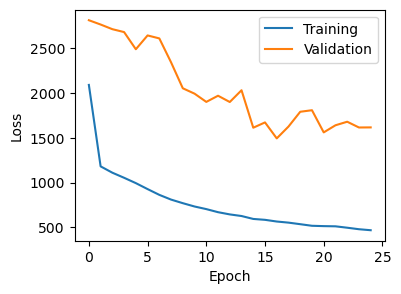

Training loss 468.3130319425375 is less than half of validation loss 1615.29025233477


In [ ]:
from src import train_model

lr = 0.001
epochs = 500
patientce = 50
log_input = True
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.PoissonNLLLoss(log_input=log_input, full=True)
# loss_fn = nn.MSELoss(reduction='mean')
train_model(device, train_loader, val_loader, model, optimizer, loss_fn, epochs, save_dir, patientce)

In [ ]:
X, y = next(iter(train_loader))
y_pred = model(X.to(device))
i = 2
print('Tissue: Predicted, True')
for s, (y_p, y_t) in enumerate(zip(y_pred[i], y[i])):
    if log_input:
        y_p = torch.exp(y_p)
    print(f'{s}: {y_p:.3f}, {y_t:.3f}')

Tissue: Predicted, True
0: 1977.506, 1715.621
1: 2659.545, 3049.976
2: 2065.136, 4346.448
3: 2675.149, 3261.395
4: 2054.553, 3370.879
5: 1980.276, 3569.855
6: 2651.268, 2909.299
7: 2489.771, 2752.760
8: 1916.694, 2420.043
9: 2192.897, 3263.558
10: 2865.502, 4470.216
11: 2132.651, 4741.164
12: 2609.085, 3096.535
13: 1899.892, 2688.330
14: 2161.285, 2297.509
15: 1875.759, 1857.022
16: 1838.173, 4037.797
17: 2511.685, 3231.345
18: 2030.265, 1970.215
19: 2354.772, 3274.406
20: 1925.446, 2820.045
21: 2423.334, 2927.382
22: 1896.135, 2009.786
23: 3055.636, 2833.167
24: 1559.412, 1512.527
25: 2337.154, 2600.644
26: 1779.444, 2051.756
27: 3056.411, 4830.658
28: 2043.542, 1898.034
29: 1902.081, 2914.947
30: 2332.454, 2319.748
31: 1892.732, 3202.987
32: 2892.677, 3044.658
33: 3054.284, 4970.333
34: 2318.897, 2454.740
35: 2479.953, 1.000
36: 1805.741, 2302.123


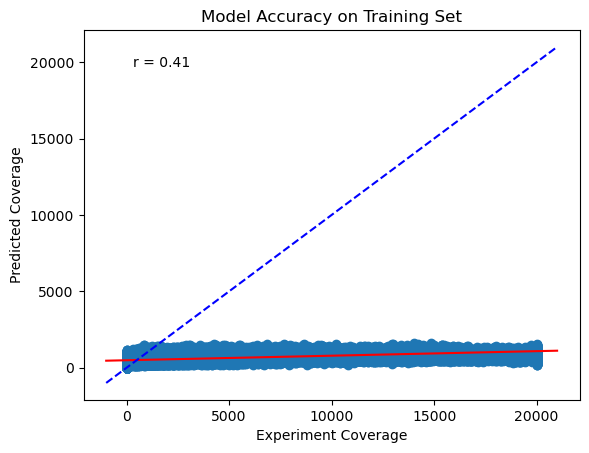

In [ ]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            if log_input:
                y_pred = torch.exp(model(X))
            else:
                y_pred = model(X)
            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Training Set")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.plot(X_plot, X_plot, '--', color='blue', label='y = x')
plt.savefig(os.path.join(save_dir, 'TrainingAccuracy.png'), dpi=300)
plt.show()

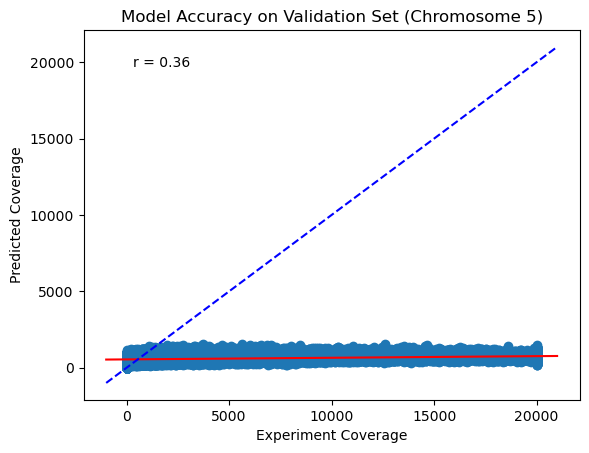

In [ ]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(val_loader):
            X = X.to(device)
            y = y.to(device)

            if log_input:
                y_pred = torch.exp(model(X))
            else:
                y_pred = model(X)

            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Validation Set (Chromosome 5)")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.plot(X_plot, X_plot, '--', color='blue', label='y = x')
plt.savefig(os.path.join(save_dir, 'ValAccuracy.png'), dpi=300)
plt.show()

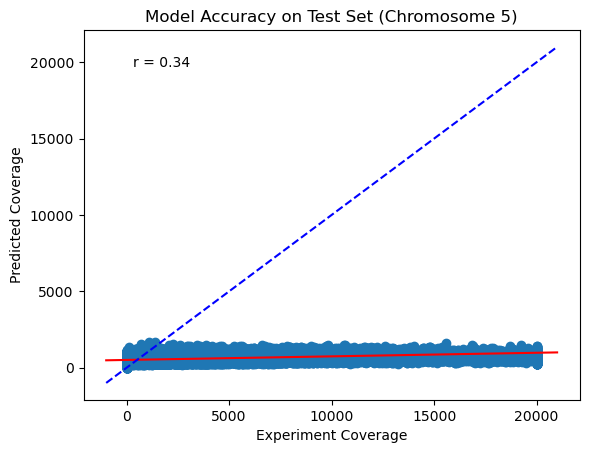

In [ ]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(test_loader):
            X = X.to(device)
            y = y.to(device)
            if log_input:
                y_pred = torch.exp(model(X))
            else:
                y_pred = model(X)
            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Test Set (Chromosome 5)")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.plot(X_plot, X_plot, '--', color='blue', label='y = x')
plt.savefig(os.path.join(save_dir, 'TestingAccuracy.png'), dpi=300)
plt.show()